# kuの推定

NME_2021を参考にkuを推定する。
$$
J(t) = J_f \left( \frac{A(t) - 1}{A(t) + 1} \right)^2
$$

$$
A(t) = \frac{1 + \sqrt{J_i / J_f}}{1 - \sqrt{J_i / J_f}} \exp(\lambda t)
$$

$$
\lambda = \frac{2(k_u + k_d) \sqrt{J_f}}{\sqrt{k_d} L}
$$

$$
J(0) = J_i
$$

J_i is the steady state permeation flux before discharge termination

J_f is the permeation flux after discharge termination

In [ ]:
import os
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from quest_pp_calibration.flux_analysis import FluxDecayModel

plt.rcParams["font.weight"] = "normal"
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (6.4, 4.8)

### Import data

In [14]:
shot = 34314
date = 170112

# 04_check_concentration/check_concentration_170112.ipynb
perm_at_first = 2.06e+14
kd = 5.0e-31

pp_pth = os.path.expanduser(f"../../../data/calibrated/{date}")
filename = '34314_PDP8_calibrated_winsma30_win71_win1-7_w15-range35_s2.txt'

df = pd.read_csv(join(pp_pth,filename), sep=r'\s+', header=None)

num_cols = df.select_dtypes('number').columns

x = df[num_cols[0]]
y = df[num_cols[1]]

xx = np.linspace(x.min(),x.max(),len(x))
fy = interp1d(x,y)
yy = fy(xx)

yy += perm_at_first

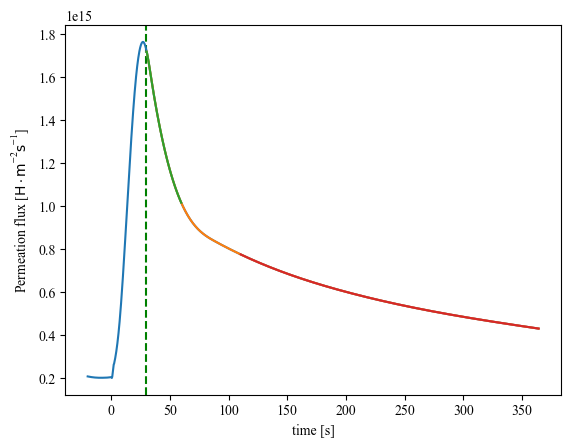

In [15]:
decay_start = 30
plt.axvline(x=decay_start, color='green', linestyle='--', label=f'x = {decay_start}')

ind_a = np.where((xx < xx[-1] - 50))
ax, ay = (xx[ind_a], yy[ind_a])

ind_b = np.where((ax > decay_start))
bx, by = (ax[ind_b], ay[ind_b])

ind_c = np.where((ax > decay_start)&(ax < 60))
cx, cy = (ax[ind_c], ay[ind_c])

ind_d = np.where((ax > 110))
dx, dy = (ax[ind_d], ay[ind_d])

plt.plot(ax, ay,)
plt.plot(bx, by,)
plt.plot(cx, cy,)
plt.plot(dx, dy,)

plt.xlabel('time [s]')
plt.ylabel(r'Permeation flux [$\mathrm{H} \cdot \mathrm{m}^{-2} \mathrm{s}^{-1}$]')
plt.show()

In [16]:
_, y_exponent_str = f"{max(ay):e}".split('e')

y_exponent = int(y_exponent_str)
y_order = 10 ** y_exponent

calc_time_b = bx - bx[0]
calc_time_c = cx - bx[0]
calc_time_d = dx - dx[0]

### 前半・後半でそれぞれ計算

In [17]:
# インスタンス化
model_first = FluxDecayModel(kd=kd, ji=cy[0])
# 最適化の実行
ku_opt_first = model_first.fit_ku(calc_time_c, cy)
details_first = model_first.ku_details
ku_mantissa_first = details_first['mantissa']
ku_exponent_first = details_first['exponent']


# インスタンス化
model_second = FluxDecayModel(kd=kd, ji=dy[0])
# 最適化の実行
ku_opt_second = model_second.fit_ku(calc_time_d, dy)
details_second = model_second.ku_details
ku_mantissa_second = details_second['mantissa']
ku_exponent_second = details_second['exponent']

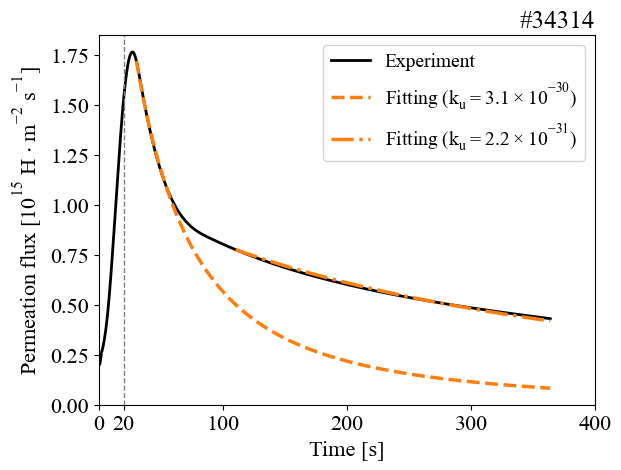

In [18]:
fig, axes = plt.subplots()

axes.plot(ax, ay/y_order, '-', label="Experiment", color='black', markersize=2, linewidth=2)
axes.plot(bx, model_first.flux_function(calc_time_b, model_first.log_ku_opt)/y_order, '--',
        label=rf"Fitting ($k_u = {ku_mantissa_first:.1f} \times 10^{{{ku_exponent_first}}}$)",
        color='tab:orange', linewidth=2.5)
axes.plot(dx, model_second.flux_function(calc_time_d, model_second.log_ku_opt)/y_order, '-.',
        label=rf"Fitting ($k_u = {ku_mantissa_second:.1f} \times 10^{{{ku_exponent_second}}}$)",
        color='tab:orange', linewidth=2.5)

axes.set_xlim(left=0)
axes.set_ylim(bottom=0)
axes.tick_params(labelsize=16)
axes.set_xlabel("Time [s]", fontsize=16)
axes.set_ylabel(rf'Permeation flux [$10^{{{y_exponent}}}$ H $\cdot$ m$^{{-2}}$ s$^{{-1}}$]', fontsize=16)
axes.legend(fontsize=14)

plt.xticks([0, 20, 100, 200, 300, 400])
axes.axvline(x=20, color='gray', linestyle='--', linewidth=1)

axes.text(1, 1.07, f"#{shot}",
    transform=axes.transAxes, fontsize=18,
    ha="right", va="top")

plt.show()
